
#### Основы нейронных сетей


#### Многослойная сеть на PyTorch

В этом ноутбке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать многослойную полносвязную сеть (Fully-Connected, FC), и сравним их качество на датасете картинок MNIST.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Многослойная нейронная сеть</b></h3>

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Каждый слой состоит из **нейронов**. Ранее мы уже писали свой нейрон на NumPy, вот из таких нейронов и состоит ***MLP (Multi-Layer Perceptron)***. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть у нейронов со слоя $L_{i-1}$  и нейронов $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** на **выходном слое** обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на **выходном слое** обычно один нейрон, если задача бинарной классификации, и $K$ нейронов, если задача $K$-класовой классификации.

#### Forward pass в MLP

Каждый слой многослойной нейросети - это матрица весов, строки которой - это нейроны (одна строка - один нейрон), а столбцы - веса каждого нейрона (то есть одна строка - это веса одного нейрона).

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix} 
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM} 
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1} 
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, у второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2} 
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix} 
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK} 
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге ***для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации***.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации).

**Backward pass в MLP**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

## Датасет
Мы будем работать с датасетом "Игрушка дьявола". Генерация и отрисовка датасета:

In [35]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

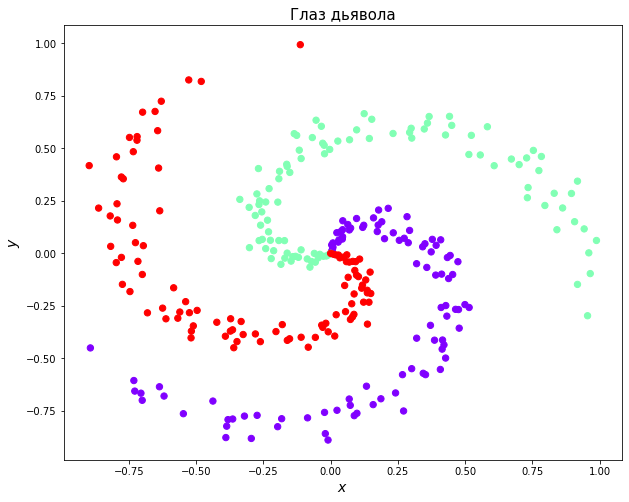

In [36]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Глаз дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

<h3 style="text-align: center;"><b>Многослойная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

## PyTorch для нейронных сетей

Основная абстракция для построения нейронной сети --- это torch.nn.Module. Module --- это те кирпичики, из которых мы будем складывать любую нейронную сеть. Как мы узнали на лекции, для определения модуля достаточно задать методы Forward и Backward. Базовый класс для nn.Module в PyTorch:



In [2]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    


### Модуль Sequential

Основной класс в PyTorch для работы с нейронными сетями --- это  Sequential.  Sequential --- это шаблон для самой простой последовательной нейронной сети. Методы Forward и Backward заданы соответственно: мы пробрасываем выходы и градиенты через все слои, из которых состоит Module. Посмотрим, как это работает.

Не будем медлить - бахнем 100 нейронов в двуслойную нейросеть. 

In [38]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 64, 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Посмотрим, что у нас получилось. Пропустим мусорные данные через нашу модель методом forward.

In [39]:
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

Weight shapes: [torch.Size([100, 2]), torch.Size([100]), torch.Size([3, 100]), torch.Size([3])]


In [40]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.3041, 0.2951, 0.4008], grad_fn=<SelectBackward>)

## Код для генерации мини-батчей



In [3]:
from torch.autograd import Variable

In [41]:
def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [10]:
batch_gen(X, y)[1].shape

torch.Size([128])

In [11]:
two_layer_net.forward(batch_gen(X,y)[0])

tensor([[0.3567, 0.3175, 0.3258],
        [0.3732, 0.2837, 0.3431],
        [0.3629, 0.3240, 0.3130],
        [0.3311, 0.3583, 0.3107],
        [0.3545, 0.3449, 0.3006],
        [0.3466, 0.2919, 0.3616],
        [0.3661, 0.3255, 0.3084],
        [0.3515, 0.3496, 0.2989],
        [0.3466, 0.3253, 0.3281],
        [0.3500, 0.3244, 0.3255],
        [0.3235, 0.3462, 0.3302],
        [0.3301, 0.3592, 0.3107],
        [0.3536, 0.3456, 0.3008],
        [0.3292, 0.3494, 0.3214],
        [0.3632, 0.3305, 0.3064],
        [0.3228, 0.3577, 0.3195],
        [0.3600, 0.2808, 0.3592],
        [0.3517, 0.2913, 0.3571],
        [0.3440, 0.3384, 0.3176],
        [0.3543, 0.3164, 0.3293],
        [0.3528, 0.3469, 0.3003],
        [0.3617, 0.2905, 0.3477],
        [0.3428, 0.3351, 0.3221],
        [0.3629, 0.3240, 0.3130],
        [0.3623, 0.3286, 0.3091],
        [0.3477, 0.3526, 0.2997],
        [0.3566, 0.3323, 0.3110],
        [0.3301, 0.3592, 0.3107],
        [0.3444, 0.3048, 0.3508],
        [0.356

Не забываем оборачивать данные (без этого градиенты не посчитать):

## Функция потерь и оптимизатор

In [12]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

c:\programdata\miniconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Обучение модели

In [13]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 141.3050537109375
1 141.88885498046875
2 141.64666748046875
3 141.6089630126953
4 141.88450622558594
5 141.26400756835938
6 141.24830627441406
7 141.74937438964844
8 141.4946746826172
9 141.3002471923828
10 141.76608276367188
11 140.99859619140625
12 141.49826049804688
13 141.23834228515625
14 140.75204467773438
15 141.78045654296875
16 141.46456909179688
17 141.01364135742188
18 141.1837158203125
19 140.85598754882812
20 140.82205200195312
21 141.0098419189453
22 140.8290557861328
23 141.23619079589844
24 140.6264190673828
25 141.29348754882812
26 140.83863830566406
27 140.50698852539062
28 140.65811157226562
29 141.1649627685547
30 141.44017028808594
31 140.3545684814453
32 140.3629150390625
33 140.46385192871094
34 140.9231719970703
35 140.42495727539062
36 140.3784637451172
37 140.597412109375
38 141.4778594970703
39 140.86737060546875
40 140.33221435546875
41 140.96705627441406
42 140.3850860595703
43 140.647216796875
44 140.5434112548828
45 140.82351684570312
46 140.46745300292

474 128.406005859375
475 131.22756958007812
476 132.03102111816406
477 131.2720947265625
478 132.6968231201172
479 128.37339782714844
480 130.25608825683594
481 131.54855346679688
482 130.45399475097656
483 129.23780822753906
484 130.13681030273438
485 129.4590301513672
486 130.62448120117188
487 130.53329467773438
488 129.8229522705078
489 129.55331420898438
490 130.10154724121094
491 130.08116149902344
492 130.88450622558594
493 130.96142578125
494 130.81297302246094
495 130.08694458007812
496 131.5391845703125
497 129.035400390625
498 131.3485565185547
499 130.0666046142578
500 130.0731201171875
501 130.09951782226562
502 130.69561767578125
503 130.11842346191406
504 130.0203399658203
505 127.80110931396484
506 130.88160705566406
507 131.6942596435547
508 129.75753784179688
509 132.38558959960938
510 127.91133880615234
511 127.07606506347656
512 130.25393676757812
513 130.05938720703125
514 127.75001525878906
515 130.96926879882812
516 129.16757202148438
517 129.12098693847656
518 1

953 121.09217071533203
954 125.02579498291016
955 122.87425231933594
956 125.64786529541016
957 121.79822540283203
958 125.63105010986328
959 124.81185150146484
960 120.39673614501953
961 123.88526916503906
962 121.67819213867188
963 125.3342514038086
964 125.61600494384766
965 123.43168640136719
966 125.33039855957031
967 121.72492218017578
968 122.32292175292969
969 127.22054290771484
970 122.78302001953125
971 122.891357421875
972 122.07489776611328
973 127.13258361816406
974 124.1215591430664
975 126.1859130859375
976 126.74168395996094
977 125.45830535888672
978 122.31929779052734
979 121.98353576660156
980 121.55596923828125
981 120.59293365478516
982 120.26582336425781
983 122.72267150878906
984 125.30088806152344
985 124.08158111572266
986 123.83470916748047
987 125.92882537841797
988 126.61494445800781
989 124.2144546508789
990 124.62138366699219
991 121.2672348022461
992 124.67327880859375
993 127.32412719726562
994 121.07154846191406
995 121.18730163574219
996 123.0446853637

1453 119.02079010009766
1454 120.66827392578125
1455 121.64129638671875
1456 120.32750701904297
1457 118.36228942871094
1458 121.7621841430664
1459 121.08847045898438
1460 120.7248306274414
1461 120.55428314208984
1462 120.38385772705078
1463 119.00348663330078
1464 117.69375610351562
1465 117.61277770996094
1466 122.16383361816406
1467 117.2901382446289
1468 120.6006851196289
1469 119.04777526855469
1470 114.97573852539062
1471 123.46175384521484
1472 122.40516662597656
1473 120.6031723022461
1474 118.49765014648438
1475 121.47464752197266
1476 118.05802917480469
1477 116.68220520019531
1478 119.08295440673828
1479 122.34199523925781
1480 119.17925262451172
1481 123.88473510742188
1482 119.82891082763672
1483 120.60242462158203
1484 118.0609130859375
1485 121.78235626220703
1486 116.06279754638672
1487 117.93295288085938
1488 120.6646957397461
1489 119.90958404541016
1490 123.56253051757812
1491 122.16544342041016
1492 119.31962585449219
1493 119.11058807373047
1494 122.1891098022461


1963 121.70597839355469
1964 113.13684844970703
1965 119.22992706298828
1966 116.7372055053711
1967 114.16497039794922
1968 120.38478088378906
1969 118.26422119140625
1970 119.58601379394531
1971 116.53346252441406
1972 118.71778106689453
1973 119.2799301147461
1974 118.26106262207031
1975 117.02335357666016
1976 117.1853256225586
1977 117.43222045898438
1978 118.72340393066406
1979 116.54852294921875
1980 117.87488555908203
1981 119.08384704589844
1982 113.40557861328125
1983 120.44174194335938
1984 114.99210357666016
1985 117.40199279785156
1986 120.65301513671875
1987 118.96082305908203
1988 121.53368377685547
1989 114.53543090820312
1990 122.00243377685547
1991 114.72874450683594
1992 122.4289321899414
1993 116.85377502441406
1994 116.15914154052734
1995 118.52339935302734
1996 116.66171264648438
1997 117.87498474121094
1998 116.58399963378906
1999 116.29713439941406
2000 116.49380493164062
2001 119.82746887207031
2002 114.30455780029297
2003 119.91382598876953
2004 120.72446441650

2431 118.63794708251953
2432 116.9394760131836
2433 115.62157440185547
2434 119.13353729248047
2435 118.09085083007812
2436 115.62760162353516
2437 117.78997802734375
2438 115.5396499633789
2439 120.19742584228516
2440 116.09355163574219
2441 114.5210189819336
2442 119.40045166015625
2443 118.7846908569336
2444 115.17992401123047
2445 115.50070190429688
2446 112.73290252685547
2447 116.6117172241211
2448 116.5635986328125
2449 115.72722625732422
2450 115.53926849365234
2451 112.24695587158203
2452 117.11363983154297
2453 117.70813751220703
2454 113.88343811035156
2455 114.63153076171875
2456 117.92168426513672
2457 111.9344482421875
2458 118.48179626464844
2459 118.43739318847656
2460 115.92166900634766
2461 113.45970916748047
2462 121.98140716552734
2463 117.07479858398438
2464 113.02323913574219
2465 116.39287567138672
2466 116.70311737060547
2467 119.77460479736328
2468 114.8759994506836
2469 115.36029052734375
2470 115.17066192626953
2471 115.10494232177734
2472 118.83229064941406


2857 114.40778350830078
2858 113.32190704345703
2859 112.18196105957031
2860 117.40283966064453
2861 115.28724670410156
2862 115.86109161376953
2863 118.15022277832031
2864 117.08860778808594
2865 113.5184555053711
2866 115.38673400878906
2867 117.57219696044922
2868 120.02967071533203
2869 117.62162017822266
2870 112.59548950195312
2871 114.09283447265625
2872 119.16715240478516
2873 116.2555923461914
2874 117.77165985107422
2875 116.9168701171875
2876 117.19450378417969
2877 119.80217742919922
2878 113.56614685058594
2879 118.2054672241211
2880 114.22879028320312
2881 110.97826385498047
2882 112.67671203613281
2883 114.37726593017578
2884 118.1884765625
2885 114.09125518798828
2886 113.91606140136719
2887 120.65815734863281
2888 118.78916931152344
2889 113.60550689697266
2890 117.2633056640625
2891 117.441162109375
2892 115.47135925292969
2893 115.97615814208984
2894 114.81855010986328
2895 116.70592498779297
2896 117.0689468383789
2897 113.21432495117188
2898 109.41533660888672
2899

3269 114.34600067138672
3270 111.14347076416016
3271 113.55085754394531
3272 119.1380615234375
3273 115.14908599853516
3274 118.908935546875
3275 114.71896362304688
3276 112.41642761230469
3277 117.20159912109375
3278 115.96148681640625
3279 115.4703140258789
3280 118.78497314453125
3281 114.6903076171875
3282 112.20317077636719
3283 115.75008392333984
3284 117.3953628540039
3285 116.0105209350586
3286 114.89804077148438
3287 118.07917022705078
3288 117.22970581054688
3289 110.98616027832031
3290 114.19119262695312
3291 117.40032196044922
3292 112.23159790039062
3293 115.1555404663086
3294 115.08666229248047
3295 114.26473999023438
3296 118.90009307861328
3297 108.37648010253906
3298 115.15554809570312
3299 112.84365844726562
3300 115.03990173339844
3301 115.80004119873047
3302 113.45472717285156
3303 112.42918395996094
3304 116.19648742675781
3305 116.17899322509766
3306 119.35518646240234
3307 112.37684631347656
3308 108.89776611328125
3309 116.67035675048828
3310 116.76386260986328


3703 112.66893005371094
3704 118.4925308227539
3705 115.52647399902344
3706 117.5915298461914
3707 117.71739196777344
3708 112.37889862060547
3709 115.43986511230469
3710 112.4876708984375
3711 117.48951721191406
3712 113.80354309082031
3713 119.4428939819336
3714 115.19152069091797
3715 109.3105239868164
3716 111.99248504638672
3717 112.97393035888672
3718 115.00373840332031
3719 113.31470489501953
3720 108.11555480957031
3721 114.88920593261719
3722 112.3030776977539
3723 115.41545867919922
3724 124.6564712524414
3725 116.92462921142578
3726 110.17320251464844
3727 114.5665512084961
3728 112.84523010253906
3729 114.89994812011719
3730 118.0279541015625
3731 111.8849868774414
3732 113.7830581665039
3733 108.56816101074219
3734 114.97750091552734
3735 114.21211242675781
3736 114.3744125366211
3737 115.72633361816406
3738 111.70475769042969
3739 113.87263488769531
3740 115.85079193115234
3741 114.68218994140625
3742 112.04235076904297
3743 117.70159912109375
3744 112.92463684082031
3745

4176 110.75553894042969
4177 114.00862884521484
4178 111.17377471923828
4179 109.9926528930664
4180 113.17146301269531
4181 111.48920440673828
4182 111.73313903808594
4183 116.57642364501953
4184 113.32524108886719
4185 111.54185485839844
4186 112.22167205810547
4187 106.82350158691406
4188 113.61132049560547
4189 113.9282455444336
4190 113.95584106445312
4191 115.9481430053711
4192 115.77120971679688
4193 115.93502807617188
4194 109.98665618896484
4195 117.77236938476562
4196 109.80671691894531
4197 115.46054077148438
4198 114.07077026367188
4199 115.05094909667969
4200 108.8884506225586
4201 110.0383071899414
4202 112.34552001953125
4203 114.08604431152344
4204 111.97572326660156
4205 115.58258056640625
4206 122.7633285522461
4207 108.32942199707031
4208 112.40138244628906
4209 111.67831420898438
4210 114.58074951171875
4211 115.95804595947266
4212 109.35679626464844
4213 115.14437103271484
4214 114.75846099853516
4215 110.75977325439453
4216 114.04542541503906
4217 112.0296096801757

4525 116.79540252685547
4526 112.5081787109375
4527 119.53170776367188
4528 112.26197052001953
4529 110.1926040649414
4530 113.19863891601562
4531 112.86122131347656
4532 112.96845245361328
4533 112.69580078125
4534 112.81578063964844
4535 116.53215789794922
4536 119.82964324951172
4537 114.80682373046875
4538 112.00257873535156
4539 112.04434967041016
4540 110.44496154785156
4541 113.62225341796875
4542 114.026123046875
4543 112.72724151611328
4544 112.08448028564453
4545 114.64759826660156
4546 113.2932357788086
4547 112.04312133789062
4548 113.1012191772461
4549 115.84464263916016
4550 111.45537567138672
4551 113.05152130126953
4552 115.70336151123047
4553 110.88423156738281
4554 112.43109130859375
4555 111.69285583496094
4556 110.95348358154297
4557 113.04765319824219
4558 119.4255142211914
4559 115.0673599243164
4560 114.23471069335938
4561 110.54627990722656
4562 112.31825256347656
4563 107.38008117675781
4564 111.86334991455078
4565 106.7142562866211
4566 115.39669036865234
4567

4956 114.20568084716797
4957 111.6432876586914
4958 112.32972717285156
4959 108.54804229736328
4960 113.13782501220703
4961 119.28778076171875
4962 108.85252380371094
4963 111.50199127197266
4964 109.70460510253906
4965 114.83540344238281
4966 113.90412902832031
4967 117.19111633300781
4968 114.4896469116211
4969 115.94771575927734
4970 107.4366683959961
4971 115.8211898803711
4972 115.42378234863281
4973 112.95423889160156
4974 109.37763214111328
4975 109.50991821289062
4976 111.68804168701172
4977 112.92874908447266
4978 106.49887084960938
4979 113.24168395996094
4980 112.53839874267578
4981 114.52758026123047
4982 109.68775177001953
4983 112.19052124023438
4984 113.90843963623047
4985 115.43257141113281
4986 111.5745849609375
4987 109.6095199584961
4988 105.6202392578125
4989 114.79666900634766
4990 107.90213012695312
4991 108.19221496582031
4992 107.17378997802734
4993 117.25682830810547
4994 110.03324127197266
4995 115.53424072265625
4996 108.39718627929688
4997 109.74842071533203

5361 109.86275482177734
5362 112.61846923828125
5363 115.36658477783203
5364 110.64812469482422
5365 113.20713806152344
5366 113.41437530517578
5367 109.59120178222656
5368 111.83821105957031
5369 115.57201385498047
5370 108.31648254394531
5371 117.50984954833984
5372 117.9779281616211
5373 111.37742614746094
5374 111.0159683227539
5375 110.16150665283203
5376 111.60586547851562
5377 114.66987609863281
5378 115.73235321044922
5379 112.21080780029297
5380 111.53349304199219
5381 108.48284149169922
5382 108.34795379638672
5383 108.57659912109375
5384 109.1652603149414
5385 111.08985137939453
5386 108.02571105957031
5387 112.67252349853516
5388 113.2564926147461
5389 112.26388549804688
5390 111.16517639160156
5391 108.0364761352539
5392 113.54483032226562
5393 112.58133697509766
5394 113.32791900634766
5395 111.36317443847656
5396 112.57879638671875
5397 116.0653076171875
5398 116.2353286743164
5399 115.26148986816406
5400 113.24126434326172
5401 107.88186645507812
5402 114.27429962158203

5747 112.3322982788086
5748 115.75630950927734
5749 108.44831085205078
5750 102.18904113769531
5751 109.0238265991211
5752 110.31156158447266
5753 109.12278747558594
5754 111.91049194335938
5755 108.66769409179688
5756 113.81430053710938
5757 122.1394271850586
5758 109.2191390991211
5759 112.09673309326172
5760 110.75220489501953
5761 112.74092864990234
5762 106.94483947753906
5763 110.44966888427734
5764 112.46099090576172
5765 109.34778594970703
5766 113.87220001220703
5767 110.00144958496094
5768 103.6761703491211
5769 107.670654296875
5770 114.76123046875
5771 113.16325378417969
5772 109.22637176513672
5773 108.66944122314453
5774 113.0172348022461
5775 115.96139526367188
5776 113.17933654785156
5777 109.2696533203125
5778 112.29579162597656
5779 112.92938232421875
5780 111.35385131835938
5781 112.11324310302734
5782 115.97945404052734
5783 117.69096374511719
5784 113.23503875732422
5785 109.72724914550781
5786 115.20024108886719
5787 114.20549774169922
5788 110.67613983154297
5789

6115 110.09959411621094
6116 110.33007049560547
6117 111.40860748291016
6118 112.78612518310547
6119 112.37638854980469
6120 107.76840209960938
6121 111.8566665649414
6122 109.505615234375
6123 113.45573425292969
6124 115.49508666992188
6125 110.045166015625
6126 106.84485626220703
6127 109.67361450195312
6128 115.23595428466797
6129 113.89878845214844
6130 111.54019927978516
6131 109.55145263671875
6132 111.15177154541016
6133 107.04995727539062
6134 112.27751159667969
6135 109.58810424804688
6136 111.28927612304688
6137 107.29403686523438
6138 113.0950927734375
6139 111.2392349243164
6140 113.97042846679688
6141 113.05316162109375
6142 107.52767181396484
6143 112.98970031738281
6144 111.15801239013672
6145 111.77404022216797
6146 112.30635833740234
6147 115.91572570800781
6148 108.39635467529297
6149 111.52894592285156
6150 111.08421325683594
6151 114.38465881347656
6152 110.23230743408203
6153 108.33172607421875
6154 109.34759521484375
6155 111.73068237304688
6156 112.99786376953125

6522 110.55184173583984
6523 107.52120971679688
6524 112.71729278564453
6525 108.47797393798828
6526 114.13890075683594
6527 110.06043243408203
6528 105.4165267944336
6529 109.48175048828125
6530 114.11076354980469
6531 111.50874328613281
6532 109.18556213378906
6533 109.32455444335938
6534 109.95478820800781
6535 112.31269073486328
6536 109.15077209472656
6537 108.96224975585938
6538 113.4328842163086
6539 108.7347412109375
6540 117.40447998046875
6541 110.73350524902344
6542 109.06302642822266
6543 111.67264556884766
6544 110.2701644897461
6545 109.40653228759766
6546 111.91557312011719
6547 113.89679718017578
6548 106.13951873779297
6549 111.19402313232422
6550 112.61077117919922
6551 108.01631927490234
6552 111.66053771972656
6553 114.8976058959961
6554 117.13432312011719
6555 112.2165756225586
6556 111.5114974975586
6557 108.97053527832031
6558 111.87372589111328
6559 109.01222229003906
6560 106.49549865722656
6561 109.59213256835938
6562 112.17857360839844
6563 111.59236907958984

7003 105.88370513916016
7004 107.54491424560547
7005 108.75209045410156
7006 112.31011199951172
7007 109.26708984375
7008 110.89857482910156
7009 108.5138931274414
7010 111.48719024658203
7011 114.81584930419922
7012 105.68224334716797
7013 109.38033294677734
7014 116.16109466552734
7015 114.63321685791016
7016 108.6637954711914
7017 106.26737213134766
7018 111.42578125
7019 112.55552673339844
7020 112.09526062011719
7021 107.57502746582031
7022 107.05159759521484
7023 111.37706756591797
7024 113.98572540283203
7025 106.18026733398438
7026 108.61052703857422
7027 110.21187591552734
7028 106.09647369384766
7029 110.5219955444336
7030 109.47559356689453
7031 108.86155700683594
7032 108.47152709960938
7033 106.70541381835938
7034 112.36465454101562
7035 104.49331665039062
7036 108.5567398071289
7037 110.96006774902344
7038 109.51110076904297
7039 100.5041275024414
7040 110.27633666992188
7041 112.3387222290039
7042 110.08104705810547
7043 115.41577911376953
7044 112.1093978881836
7045 108

7354 107.5670394897461
7355 108.13153839111328
7356 105.6784896850586
7357 115.34368133544922
7358 105.38348388671875
7359 107.48607635498047
7360 112.12579345703125
7361 109.75887298583984
7362 109.77375793457031
7363 105.53856658935547
7364 107.42463684082031
7365 112.81825256347656
7366 107.95742797851562
7367 109.33885192871094
7368 113.4184341430664
7369 111.72863006591797
7370 112.92819213867188
7371 114.38206481933594
7372 106.3409423828125
7373 110.6338882446289
7374 114.21875
7375 113.22347259521484
7376 111.7197494506836
7377 107.93871307373047
7378 106.41425323486328
7379 109.0058822631836
7380 114.04608154296875
7381 110.70552062988281
7382 112.80188751220703
7383 113.4323959350586
7384 108.2496337890625
7385 109.06912994384766
7386 109.3333740234375
7387 107.76345825195312
7388 107.51411437988281
7389 107.10338592529297
7390 104.11497497558594
7391 104.70406341552734
7392 106.13394927978516
7393 107.54617309570312
7394 108.10338592529297
7395 105.03260040283203
7396 109.20

7845 107.13652038574219
7846 105.33396911621094
7847 110.26493072509766
7848 112.51622009277344
7849 111.90901184082031
7850 108.49994659423828
7851 107.31766510009766
7852 108.97872924804688
7853 113.68929290771484
7854 105.59188842773438
7855 102.9276351928711
7856 110.49173736572266
7857 108.00223541259766
7858 108.44248962402344
7859 106.57508850097656
7860 108.90312957763672
7861 107.47003173828125
7862 112.14656066894531
7863 109.32199096679688
7864 107.54745483398438
7865 106.6151351928711
7866 109.36077117919922
7867 102.79995727539062
7868 110.03251647949219
7869 105.99510955810547
7870 107.84427642822266
7871 112.05332946777344
7872 107.47118377685547
7873 99.61181640625
7874 106.46709442138672
7875 105.96876525878906
7876 106.13404846191406
7877 108.76207733154297
7878 109.28378295898438
7879 108.17408752441406
7880 106.6444091796875
7881 108.09629821777344
7882 108.01576232910156
7883 110.12617492675781
7884 112.55619812011719
7885 112.81572723388672
7886 109.28353881835938

8261 101.07489013671875
8262 107.26075744628906
8263 107.79732513427734
8264 111.04200744628906
8265 102.88499450683594
8266 103.705810546875
8267 111.02996826171875
8268 108.84993743896484
8269 108.05003356933594
8270 108.93903350830078
8271 106.61156463623047
8272 105.91141510009766
8273 108.07804107666016
8274 110.15592956542969
8275 109.00239562988281
8276 103.4863510131836
8277 110.01168060302734
8278 111.73616790771484
8279 109.18096923828125
8280 110.98300170898438
8281 106.26834869384766
8282 102.10366821289062
8283 109.53023529052734
8284 105.49722290039062
8285 109.48918151855469
8286 109.29268646240234
8287 105.80992889404297
8288 107.8060531616211
8289 113.89368438720703
8290 109.04940795898438
8291 112.30252838134766
8292 107.16847229003906
8293 107.72333526611328
8294 107.26522827148438
8295 108.86863708496094
8296 106.11808013916016
8297 110.71527862548828
8298 109.64065551757812
8299 108.38179779052734
8300 105.27003479003906
8301 111.0164794921875
8302 111.593544006347

8665 105.86406707763672
8666 105.10814666748047
8667 107.9670181274414
8668 107.2657241821289
8669 108.71768188476562
8670 106.27424621582031
8671 109.12904357910156
8672 112.88619995117188
8673 109.32239532470703
8674 107.72676849365234
8675 109.42253875732422
8676 107.80067443847656
8677 105.96907806396484
8678 110.22621154785156
8679 108.18488311767578
8680 110.31916809082031
8681 107.05067443847656
8682 104.4010238647461
8683 103.07586669921875
8684 105.62925720214844
8685 107.74771118164062
8686 106.96619415283203
8687 103.71839141845703
8688 108.32991027832031
8689 104.52235412597656
8690 111.03763580322266
8691 111.6217041015625
8692 110.94664001464844
8693 107.28356170654297
8694 113.55803680419922
8695 106.3473892211914
8696 105.16273498535156
8697 107.96611785888672
8698 105.44701385498047
8699 105.3509292602539
8700 105.90164947509766
8701 109.48188018798828
8702 106.02820587158203
8703 104.69029235839844
8704 108.72476959228516
8705 106.63597869873047
8706 107.8419265747070

9147 108.67096710205078
9148 99.5587387084961
9149 102.72724151611328
9150 106.87834930419922
9151 105.86871337890625
9152 108.59705352783203
9153 106.28218078613281
9154 111.3232192993164
9155 107.93949127197266
9156 108.87678527832031
9157 103.11246490478516
9158 102.82672119140625
9159 109.14644622802734
9160 108.09761047363281
9161 108.4253921508789
9162 104.99464416503906
9163 107.4108657836914
9164 105.29474639892578
9165 105.94384765625
9166 107.69097137451172
9167 105.48626708984375
9168 108.16841888427734
9169 107.01356506347656
9170 102.60723114013672
9171 100.57511138916016
9172 105.35521697998047
9173 109.9063491821289
9174 101.05332946777344
9175 100.81502532958984
9176 106.71440887451172
9177 104.99981689453125
9178 105.1241455078125
9179 103.49121856689453
9180 105.76969909667969
9181 106.2040786743164
9182 106.34527587890625
9183 110.89102172851562
9184 113.37419128417969
9185 110.01864624023438
9186 111.53311157226562
9187 109.69551849365234
9188 106.87476348876953
918

9655 109.70623779296875
9656 105.77886199951172
9657 104.44963073730469
9658 105.64968872070312
9659 109.05350494384766
9660 106.20153045654297
9661 103.57605743408203
9662 107.95637512207031
9663 106.61033630371094
9664 103.81778717041016
9665 100.83208465576172
9666 100.95928955078125
9667 105.8565902709961
9668 105.6376724243164
9669 102.82306671142578
9670 111.34196472167969
9671 105.99087524414062
9672 104.89179229736328
9673 109.08543395996094
9674 104.31541442871094
9675 106.9721908569336
9676 105.1142578125
9677 105.92313385009766
9678 109.74443054199219
9679 103.54786682128906
9680 106.16936492919922
9681 109.46308898925781
9682 108.39399719238281
9683 102.3263931274414
9684 101.79240417480469
9685 104.83152770996094
9686 106.53298950195312
9687 108.1932144165039
9688 110.69458770751953
9689 108.15807342529297
9690 109.33556365966797
9691 105.39379119873047
9692 106.17423248291016
9693 103.23344421386719
9694 101.79631805419922
9695 106.28214263916016
9696 107.45240020751953
9

**Обратите внимание:** несмотря на то, что это задача 3-х классовой классификации и столбец $y$ нужно по-хорошему кодировать OneHotEncoding'ом, мы подали просто столбец из 0, 1 и 2 и всё отработало. Вывод - PyTorch сам делает OneHot в таком случае.

Проверим, насколько хороша наша сеть из 100 нейронов:

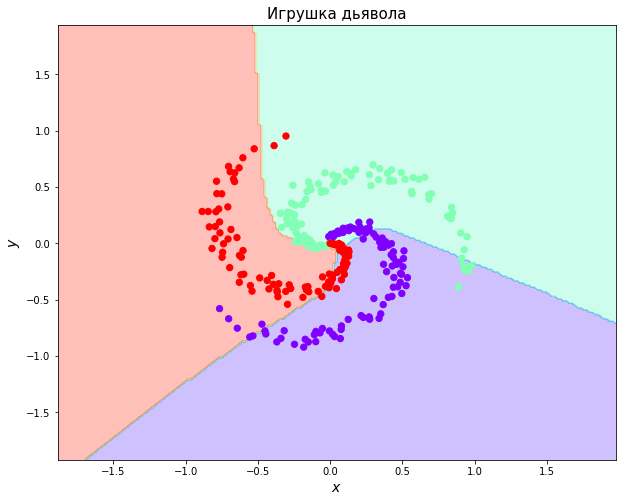

In [14]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Качество не очень. Как же так, ведь мы использовали 100 нейронов? Разве их мало?

---

### Задача 2

Улучшите сеть (помните про вещи, которые можно менять (см. Компоненты нейросети)). Экспериментируйте, в этом **вся суть deep learning** (и в том, чтобы рано или поздно сетка научилась экспериментировать за Вас :)

In [41]:
# Ваш код здесь (можно (и нужно) создавать больше ячеек)
def create_model(n_blocks=3):
    in_block = torch.nn.Sequential(torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(H),
            torch.nn.Dropout(0.5)
           )
    hidden_blocks = [torch.nn.Sequential(torch.nn.Linear(H, H),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm1d(H),
                                torch.nn.Dropout(0.5)
                                                ) for i in range(n_blocks)]


    out_block = torch.nn.Sequential(torch.nn.Linear(H, D_out),
                    torch.nn.Softmax())
    
    blocks_model = torch.nn.Sequential(
        in_block,
        *hidden_blocks,
        out_block
    )
    
    return blocks_model

c:\programdata\miniconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 143.3719940185547
1000 87.42066192626953
2000 81.92044067382812
3000 76.4072494506836
4000 77.63081359863281
5000 79.14541625976562
6000 79.1390151977539
7000 74.6076889038086
8000 74.8962173461914
9000 77.7554931640625
10000 76.1581039428711
11000 73.90161895751953
12000 73.46040344238281
13000 76.2501220703125
14000 73.34292602539062
15000 73.4881820678711
16000 75.96321105957031
17000 71.25523376464844
18000 75.25111389160156
19000 76.07225036621094
20000 71.70372009277344
21000 73.1250228881836
22000 73.32975006103516
23000 72.02012634277344
24000 71.56861114501953
25000 71.7449722290039
26000 74.51197052001953
27000 71.13594818115234
28000 72.63885498046875
29000 73.11992645263672
30000 72.50027465820312
31000 72.03472900390625
32000 74.79869079589844
33000 71.35820770263672
34000 72.02674102783203
35000 73.3241958618164
36000 72.89579010009766
37000 71.69422149658203
38000 73.7059555053711
39000 72.7846450805664
40000 74.14730834960938
41000 73.33769989013672
42000 70.710136413

0 145.4970245361328
1000 88.6272201538086
2000 83.94075775146484
3000 82.74781036376953
4000 78.79256439208984
5000 76.17810821533203
6000 77.18196105957031
7000 78.38758087158203
8000 77.03466796875
9000 80.05572509765625
10000 75.63407897949219
11000 73.01842498779297
12000 77.92422485351562
13000 72.8057632446289
14000 71.02900695800781
15000 73.34784698486328
16000 76.8979263305664
17000 74.52534484863281
18000 73.58114624023438
19000 77.0698471069336
20000 76.1474380493164
21000 73.257080078125
22000 71.86781311035156
23000 72.54417419433594
24000 75.73942565917969
25000 73.07183837890625
26000 73.63638305664062
27000 73.81452178955078
28000 75.02366638183594
29000 74.95286560058594
30000 72.28256225585938
31000 71.97838592529297
32000 71.5057373046875
33000 74.6141128540039
34000 72.86348724365234
35000 71.60787963867188
36000 73.66506958007812
37000 74.39886474609375
38000 73.56199645996094
39000 73.55242156982422
40000 72.51668548583984
41000 71.69557189941406
42000 70.63005828

0 145.4329833984375
1000 84.63248443603516
2000 77.4261245727539
3000 75.7409896850586
4000 76.8631820678711
5000 83.05248260498047
6000 77.19729614257812
7000 74.18795776367188
8000 73.71638488769531
9000 74.08926391601562
10000 75.15763092041016
11000 76.09207916259766
12000 75.82687377929688
13000 74.30027770996094
14000 74.43190002441406
15000 72.49077606201172
16000 78.14591217041016
17000 72.9483642578125
18000 73.7413101196289
19000 74.33057403564453
20000 74.63633728027344
21000 78.8948745727539
22000 71.7523422241211
23000 72.28756713867188
24000 73.174072265625
25000 74.66427612304688
26000 73.90410614013672
27000 73.52494812011719
28000 72.10871887207031
29000 72.6795425415039
30000 71.61157989501953
31000 70.6933822631836
32000 79.25089263916016
33000 70.60091400146484
34000 76.8878402709961
35000 75.59539031982422
36000 70.95455169677734
37000 74.6012954711914
38000 70.7303237915039
39000 73.47787475585938
40000 74.03610229492188
41000 70.60429382324219
42000 72.7162628173

0 139.7979278564453
1000 95.35855865478516
2000 84.99878692626953
3000 87.04936981201172
4000 77.08027648925781
5000 78.26692962646484
6000 81.46564483642578
7000 77.84954071044922
8000 76.78112030029297
9000 80.22266387939453
10000 78.9642333984375
11000 74.74585723876953
12000 73.8895034790039
13000 75.71841430664062
14000 76.03453063964844
15000 75.79341125488281
16000 75.39035034179688
17000 73.88809204101562
18000 75.55901336669922
19000 75.50111389160156
20000 73.92412567138672
21000 75.27200317382812
22000 76.2894287109375
23000 78.55501556396484
24000 72.05513763427734
25000 71.48299407958984
26000 74.9027328491211
27000 70.7541732788086
28000 73.84011840820312
29000 75.679931640625
30000 72.62059020996094
31000 75.35623931884766
32000 77.39985656738281
33000 72.6013412475586
34000 75.26629638671875
35000 71.46198272705078
36000 73.8205795288086
37000 71.76979064941406
38000 73.43246459960938
39000 73.33108520507812
40000 74.22541809082031
41000 71.46986389160156
42000 73.32547

0 144.33653259277344
1000 133.18209838867188
2000 96.17548370361328
3000 83.27571868896484
4000 83.91404724121094
5000 82.5689468383789
6000 84.72896575927734
7000 75.97270202636719
8000 76.18439483642578
9000 80.48164367675781
10000 79.81458282470703
11000 81.93975067138672
12000 80.9036636352539
13000 76.54080200195312
14000 78.05844116210938
15000 76.41998291015625
16000 76.48291015625
17000 73.50747680664062
18000 78.94686889648438
19000 78.11656188964844
20000 75.48390197753906
21000 71.96914672851562
22000 76.60395050048828
23000 77.70661163330078
24000 77.4861831665039
25000 77.79932403564453
26000 78.39260864257812
27000 75.54573822021484
28000 78.95635986328125
29000 72.69717407226562
30000 78.74341583251953
31000 74.50251770019531
32000 71.59721374511719
33000 75.60355377197266
34000 74.06895446777344
35000 75.072021484375
36000 76.54275512695312
37000 71.60395050048828
38000 74.6044692993164
39000 76.61931610107422
40000 75.27996063232422
41000 74.46907806396484
42000 74.565

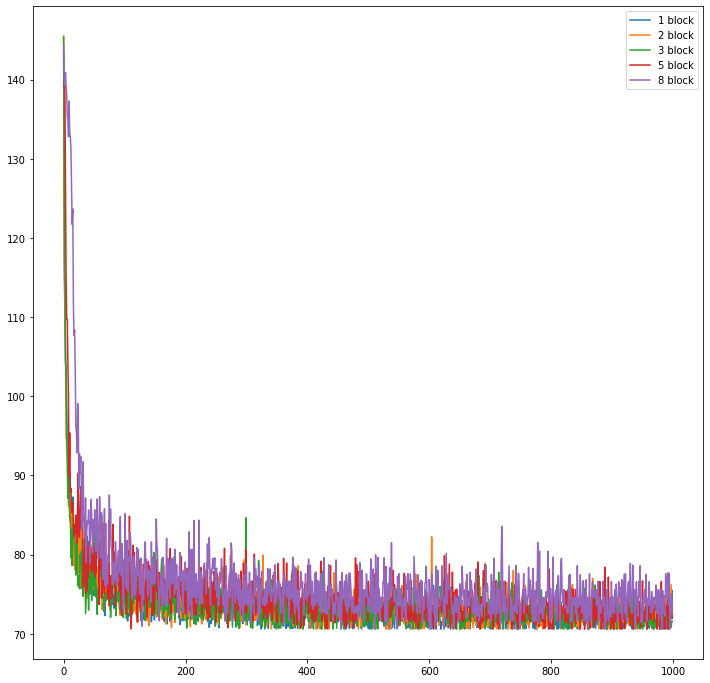

In [48]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

losses = []
for n_blocks in tqdm((1, 2, 3, 5, 8)):
    blocks_model = create_model(n_blocks)
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(blocks_model.parameters(), lr=learning_rate)
    loss_history = []
    for t in tqdm(range(100000)):
        x_batch, y_batch = batch_gen(X, y)    
        y_pred = blocks_model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        if t % 1000 == 0:
            print('{} {}'.format(t, loss.data))
        if t % 100 == 0:
            loss_history.append(loss)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(loss_history)
    
steps = np.arange(len(losses[0]))
plt.figure(figsize=(12, 12))
plt.plot(steps, losses[0], label='1 block')
plt.plot(steps, losses[1], label='2 block')
plt.plot(steps, losses[2], label='3 block')
plt.plot(steps, losses[3], label='5 block')
plt.plot(steps, losses[4], label='8 block')
plt.legend()

c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


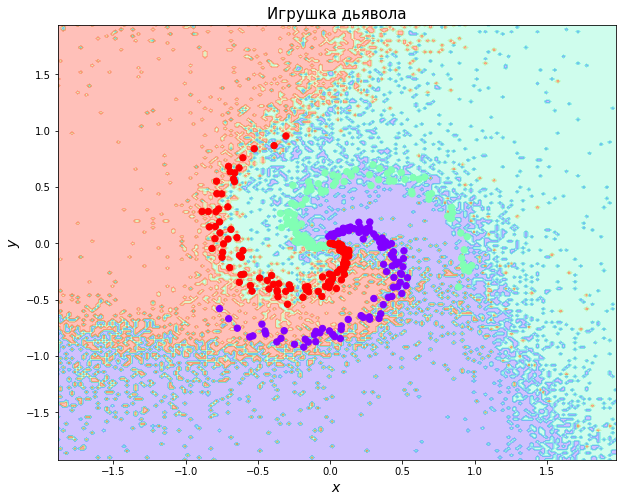

In [68]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = blocks_model(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Несколько советов о том, как строить нейросети. Код выполнен на фреймворке Keras, но, кажется, он довольно интуитивно понятен.

### Задача 2
https://pypi.org/project/python-mnist/

* __Задача:__ Распознать рукописную цифру (0-9)
* __Вход:__ картинка 28 x 28 пикселей (ч/б)

In [4]:
from mnist import MNIST
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

data = MNIST('python-mnist/data/')
train_x, train_y = data.load_training()
test_x, test_y = data.load_testing()
len(train_x), len(test_x)

(60000, 10000)

In [5]:
train_x = np.array(train_x, dtype='float32')
train_y = np.array(train_y, dtype='int64')
test_x = np.array(test_x, dtype='float32')
test_y = np.array(test_y, dtype='int64')

In [6]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
train_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
def generator(X, y, batch_size=64):
    indexes = np.random.permutation(len(X))
    for idx in range(0, len(indexes), batch_size):
        yield (torch.from_numpy(X[indexes[idx:idx+batch_size]]), torch.from_numpy(y[indexes[idx:idx+batch_size]]))

In [12]:
n_inputs = 28*28
n_outputs = 10
n_hiddens = 256

input_block = nn.Sequential(nn.Linear(n_inputs, n_hiddens),
                           nn.ReLU(),
                            nn.BatchNorm1d(n_hiddens),
                            nn.Dropout(0.5)
                           )
hidden_blocks = [nn.Sequential(nn.Linear(n_hiddens, n_hiddens),
                              nn.ReLU(),
                              nn.BatchNorm1d(n_hiddens),
                              nn.Dropout(0.5)) for i in range(3)]
output_block = nn.Sequential(nn.Linear(n_hiddens, n_outputs),
                            nn.Softmax())
model = nn.Sequential(input_block,
                     *hidden_blocks,
                     output_block)

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (4): Sequential(
    (0): Linear(in_features=256, out_features=10,

In [13]:
import math

epochs = 101
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
batch_size = 512
train_steps = math.ceil(len(train_x)/batch_size)
test_steps = math.ceil(len(test_x)/batch_size)
for epoch in tqdm(range(1, epochs)):
    model.train()
    avg_loss = 0
    avg_accuracy = 0
    for X_train, y_train in tqdm(generator(train_x, train_y, batch_size), leave=False):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        accuracy = sum(y_pred.argmax(axis=1) == y_train).numpy()/batch_size
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        avg_accuracy += accuracy
        
    train_loss_history.append(avg_loss/train_steps)
    train_accuracy_history.append(avg_accuracy/train_steps)
    
    model.eval()
    with torch.no_grad():
        avg_loss = 0
        avg_accuracy = 0
        for X_val, y_val in tqdm(generator(test_x, test_y, batch_size), leave=False):
            y_pred = model(X_val)
            loss = loss_fn(y_pred, y_val)
            accuracy = sum(y_pred.argmax(axis=1) == y_val).numpy()/batch_size
            avg_loss += loss.item()
            avg_accuracy += accuracy

        val_loss_history.append(avg_loss/test_steps)
        val_accuracy_history.append(avg_accuracy/test_steps)
    print(f'Epoch: {epoch}; Train_Loss: {round(train_loss_history[-1], 4)};  Train_Acc: {round(train_accuracy_history[-1], 4)};  Val_Loss: {round(val_loss_history[-1], 4)};  Val_Acc: {round(val_accuracy_history[-1], 4)};')

c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1; Train_Loss: 1.6975;  Train_Acc: 0.7868;  Val_Loss: 1.531;  Val_Acc: 0.9107;


Epoch: 2; Train_Loss: 1.5489;  Train_Acc: 0.9101;  Val_Loss: 1.5145;  Val_Acc: 0.9243;


Epoch: 3; Train_Loss: 1.5342;  Train_Acc: 0.9236;  Val_Loss: 1.5121;  Val_Acc: 0.9266;


Epoch: 4; Train_Loss: 1.5271;  Train_Acc: 0.9295;  Val_Loss: 1.5074;  Val_Acc: 0.9323;


Epoch: 5; Train_Loss: 1.5224;  Train_Acc: 0.9336;  Val_Loss: 1.5028;  Val_Acc: 0.9362;


Epoch: 6; Train_Loss: 1.5185;  Train_Acc: 0.9373;  Val_Loss: 1.5012;  Val_Acc: 0.9377;


Epoch: 7; Train_Loss: 1.5142;  Train_Acc: 0.9415;  Val_Loss: 1.5002;  Val_Acc: 0.9388;


Epoch: 8; Train_Loss: 1.5118;  Train_Acc: 0.9438;  Val_Loss: 1.4969;  Val_Acc: 0.9417;


Epoch: 9; Train_Loss: 1.5097;  Train_Acc: 0.9461;  Val_Loss: 1.4973;  Val_Acc: 0.9416;


Epoch: 10; Train_Loss: 1.5087;  Train_Acc: 0.9467;  Val_Loss: 1.4945;  Val_Acc: 0.9437;


Epoch: 11; Train_Loss: 1.5078;  Train_Acc: 0.9474;  Val_Loss: 1.4939;  Val_Acc: 0.9442;


Epoch: 12; Train_Loss: 1.505;  Train_Acc: 0.9502;  Val_Loss: 1.4925;  Val_Acc: 0.9459;


Epoch: 13; Train_Loss: 1.5044;  Train_Acc: 0.9509;  Val_Loss: 1.4924;  Val_Acc: 0.9465;


Epoch: 14; Train_Loss: 1.5028;  Train_Acc: 0.952;  Val_Loss: 1.4944;  Val_Acc: 0.9444;


Epoch: 15; Train_Loss: 1.5023;  Train_Acc: 0.9526;  Val_Loss: 1.4912;  Val_Acc: 0.9474;


Epoch: 16; Train_Loss: 1.5028;  Train_Acc: 0.9523;  Val_Loss: 1.4914;  Val_Acc: 0.947;


Epoch: 17; Train_Loss: 1.5029;  Train_Acc: 0.9526;  Val_Loss: 1.4907;  Val_Acc: 0.9479;


Epoch: 18; Train_Loss: 1.4991;  Train_Acc: 0.9559;  Val_Loss: 1.4915;  Val_Acc: 0.9468;


Epoch: 19; Train_Loss: 1.4994;  Train_Acc: 0.9554;  Val_Loss: 1.49;  Val_Acc: 0.9481;


Epoch: 20; Train_Loss: 1.4992;  Train_Acc: 0.9561;  Val_Loss: 1.4898;  Val_Acc: 0.9486;


Epoch: 21; Train_Loss: 1.4981;  Train_Acc: 0.9569;  Val_Loss: 1.4891;  Val_Acc: 0.9491;


Epoch: 22; Train_Loss: 1.4969;  Train_Acc: 0.9577;  Val_Loss: 1.4896;  Val_Acc: 0.949;


Epoch: 23; Train_Loss: 1.4961;  Train_Acc: 0.9584;  Val_Loss: 1.4891;  Val_Acc: 0.9487;


Epoch: 24; Train_Loss: 1.4967;  Train_Acc: 0.9582;  Val_Loss: 1.4885;  Val_Acc: 0.9504;


Epoch: 25; Train_Loss: 1.496;  Train_Acc: 0.9586;  Val_Loss: 1.4884;  Val_Acc: 0.9495;


Epoch: 26; Train_Loss: 1.4956;  Train_Acc: 0.9594;  Val_Loss: 1.4901;  Val_Acc: 0.9481;


Epoch: 27; Train_Loss: 1.4946;  Train_Acc: 0.96;  Val_Loss: 1.4892;  Val_Acc: 0.9496;


Epoch: 28; Train_Loss: 1.4941;  Train_Acc: 0.9605;  Val_Loss: 1.4871;  Val_Acc: 0.9507;


Epoch: 29; Train_Loss: 1.4942;  Train_Acc: 0.9604;  Val_Loss: 1.4876;  Val_Acc: 0.9507;


Epoch: 30; Train_Loss: 1.4936;  Train_Acc: 0.961;  Val_Loss: 1.4874;  Val_Acc: 0.9515;


Epoch: 31; Train_Loss: 1.4942;  Train_Acc: 0.9606;  Val_Loss: 1.4874;  Val_Acc: 0.9507;


Epoch: 32; Train_Loss: 1.4932;  Train_Acc: 0.9614;  Val_Loss: 1.4868;  Val_Acc: 0.9514;


Epoch: 33; Train_Loss: 1.493;  Train_Acc: 0.9616;  Val_Loss: 1.4869;  Val_Acc: 0.9512;


Epoch: 34; Train_Loss: 1.4929;  Train_Acc: 0.962;  Val_Loss: 1.4869;  Val_Acc: 0.9508;


Epoch: 35; Train_Loss: 1.4917;  Train_Acc: 0.9629;  Val_Loss: 1.4868;  Val_Acc: 0.952;


Epoch: 36; Train_Loss: 1.493;  Train_Acc: 0.9615;  Val_Loss: 1.4881;  Val_Acc: 0.9504;


Epoch: 37; Train_Loss: 1.492;  Train_Acc: 0.9625;  Val_Loss: 1.4866;  Val_Acc: 0.952;


Epoch: 38; Train_Loss: 1.492;  Train_Acc: 0.9623;  Val_Loss: 1.4867;  Val_Acc: 0.9519;


Epoch: 39; Train_Loss: 1.4917;  Train_Acc: 0.963;  Val_Loss: 1.4854;  Val_Acc: 0.9528;


Epoch: 40; Train_Loss: 1.4905;  Train_Acc: 0.9639;  Val_Loss: 1.486;  Val_Acc: 0.952;


Epoch: 41; Train_Loss: 1.4903;  Train_Acc: 0.9643;  Val_Loss: 1.4862;  Val_Acc: 0.9521;


Epoch: 42; Train_Loss: 1.49;  Train_Acc: 0.9651;  Val_Loss: 1.4865;  Val_Acc: 0.9516;


Epoch: 43; Train_Loss: 1.4902;  Train_Acc: 0.9642;  Val_Loss: 1.4867;  Val_Acc: 0.9515;


Epoch: 44; Train_Loss: 1.4904;  Train_Acc: 0.9643;  Val_Loss: 1.4866;  Val_Acc: 0.9515;


Epoch: 45; Train_Loss: 1.4911;  Train_Acc: 0.9632;  Val_Loss: 1.4866;  Val_Acc: 0.952;


Epoch: 46; Train_Loss: 1.489;  Train_Acc: 0.9653;  Val_Loss: 1.4866;  Val_Acc: 0.9523;


Epoch: 47; Train_Loss: 1.4898;  Train_Acc: 0.9647;  Val_Loss: 1.4858;  Val_Acc: 0.9522;


Epoch: 48; Train_Loss: 1.4885;  Train_Acc: 0.9662;  Val_Loss: 1.487;  Val_Acc: 0.9514;


Epoch: 49; Train_Loss: 1.4894;  Train_Acc: 0.9653;  Val_Loss: 1.4862;  Val_Acc: 0.952;


Epoch: 50; Train_Loss: 1.4893;  Train_Acc: 0.965;  Val_Loss: 1.487;  Val_Acc: 0.9513;


Epoch: 51; Train_Loss: 1.4894;  Train_Acc: 0.9649;  Val_Loss: 1.4869;  Val_Acc: 0.9517;


Epoch: 52; Train_Loss: 1.4893;  Train_Acc: 0.9655;  Val_Loss: 1.488;  Val_Acc: 0.9503;


Epoch: 53; Train_Loss: 1.4883;  Train_Acc: 0.9661;  Val_Loss: 1.4863;  Val_Acc: 0.9522;


Epoch: 54; Train_Loss: 1.4879;  Train_Acc: 0.9664;  Val_Loss: 1.4849;  Val_Acc: 0.9532;


Epoch: 55; Train_Loss: 1.4886;  Train_Acc: 0.9658;  Val_Loss: 1.4876;  Val_Acc: 0.9507;


Epoch: 56; Train_Loss: 1.4878;  Train_Acc: 0.9666;  Val_Loss: 1.4852;  Val_Acc: 0.9527;


Epoch: 57; Train_Loss: 1.4877;  Train_Acc: 0.9668;  Val_Loss: 1.4865;  Val_Acc: 0.9516;


Epoch: 58; Train_Loss: 1.4878;  Train_Acc: 0.967;  Val_Loss: 1.4866;  Val_Acc: 0.9517;


Epoch: 59; Train_Loss: 1.4883;  Train_Acc: 0.9661;  Val_Loss: 1.486;  Val_Acc: 0.952;


Epoch: 60; Train_Loss: 1.4893;  Train_Acc: 0.9648;  Val_Loss: 1.4862;  Val_Acc: 0.9517;


Epoch: 61; Train_Loss: 1.4886;  Train_Acc: 0.9658;  Val_Loss: 1.4858;  Val_Acc: 0.9528;


Epoch: 62; Train_Loss: 1.4876;  Train_Acc: 0.9669;  Val_Loss: 1.486;  Val_Acc: 0.9522;


Epoch: 63; Train_Loss: 1.4872;  Train_Acc: 0.9672;  Val_Loss: 1.4852;  Val_Acc: 0.9526;


Epoch: 64; Train_Loss: 1.4857;  Train_Acc: 0.969;  Val_Loss: 1.4854;  Val_Acc: 0.9531;


Epoch: 65; Train_Loss: 1.4859;  Train_Acc: 0.9687;  Val_Loss: 1.486;  Val_Acc: 0.9525;


Epoch: 66; Train_Loss: 1.4873;  Train_Acc: 0.9669;  Val_Loss: 1.4854;  Val_Acc: 0.9527;


Epoch: 67; Train_Loss: 1.4865;  Train_Acc: 0.968;  Val_Loss: 1.4847;  Val_Acc: 0.9536;


Epoch: 68; Train_Loss: 1.4864;  Train_Acc: 0.9684;  Val_Loss: 1.4849;  Val_Acc: 0.9532;


Epoch: 69; Train_Loss: 1.4862;  Train_Acc: 0.9681;  Val_Loss: 1.4846;  Val_Acc: 0.9536;


Epoch: 70; Train_Loss: 1.4858;  Train_Acc: 0.9687;  Val_Loss: 1.4843;  Val_Acc: 0.9535;


Epoch: 71; Train_Loss: 1.4855;  Train_Acc: 0.9688;  Val_Loss: 1.4849;  Val_Acc: 0.9532;


Epoch: 72; Train_Loss: 1.4852;  Train_Acc: 0.969;  Val_Loss: 1.4843;  Val_Acc: 0.9539;


Epoch: 73; Train_Loss: 1.4862;  Train_Acc: 0.9681;  Val_Loss: 1.484;  Val_Acc: 0.9537;


Epoch: 74; Train_Loss: 1.4846;  Train_Acc: 0.9698;  Val_Loss: 1.4844;  Val_Acc: 0.954;


Epoch: 75; Train_Loss: 1.4848;  Train_Acc: 0.9699;  Val_Loss: 1.4833;  Val_Acc: 0.9546;


Epoch: 76; Train_Loss: 1.4856;  Train_Acc: 0.969;  Val_Loss: 1.4838;  Val_Acc: 0.954;


Epoch: 77; Train_Loss: 1.4849;  Train_Acc: 0.9694;  Val_Loss: 1.4833;  Val_Acc: 0.9549;


Epoch: 78; Train_Loss: 1.4844;  Train_Acc: 0.9701;  Val_Loss: 1.4845;  Val_Acc: 0.9534;


Epoch: 79; Train_Loss: 1.485;  Train_Acc: 0.9695;  Val_Loss: 1.4844;  Val_Acc: 0.9536;


Epoch: 80; Train_Loss: 1.4846;  Train_Acc: 0.9696;  Val_Loss: 1.485;  Val_Acc: 0.953;


Epoch: 81; Train_Loss: 1.4846;  Train_Acc: 0.9696;  Val_Loss: 1.4851;  Val_Acc: 0.9532;


Epoch: 82; Train_Loss: 1.485;  Train_Acc: 0.9693;  Val_Loss: 1.4834;  Val_Acc: 0.9547;


Epoch: 83; Train_Loss: 1.4853;  Train_Acc: 0.969;  Val_Loss: 1.4844;  Val_Acc: 0.9538;


Epoch: 84; Train_Loss: 1.4846;  Train_Acc: 0.9698;  Val_Loss: 1.4834;  Val_Acc: 0.9548;


Epoch: 85; Train_Loss: 1.4849;  Train_Acc: 0.9693;  Val_Loss: 1.484;  Val_Acc: 0.954;


Epoch: 86; Train_Loss: 1.4846;  Train_Acc: 0.9696;  Val_Loss: 1.484;  Val_Acc: 0.9538;


Epoch: 87; Train_Loss: 1.4837;  Train_Acc: 0.9706;  Val_Loss: 1.4823;  Val_Acc: 0.9554;


Epoch: 88; Train_Loss: 1.4834;  Train_Acc: 0.9712;  Val_Loss: 1.4835;  Val_Acc: 0.9549;


Epoch: 89; Train_Loss: 1.4846;  Train_Acc: 0.97;  Val_Loss: 1.4828;  Val_Acc: 0.9552;


Epoch: 90; Train_Loss: 1.4841;  Train_Acc: 0.9704;  Val_Loss: 1.4836;  Val_Acc: 0.9546;


Epoch: 91; Train_Loss: 1.4836;  Train_Acc: 0.9707;  Val_Loss: 1.483;  Val_Acc: 0.9551;


Epoch: 92; Train_Loss: 1.4828;  Train_Acc: 0.9716;  Val_Loss: 1.4836;  Val_Acc: 0.9548;


Epoch: 93; Train_Loss: 1.4838;  Train_Acc: 0.9706;  Val_Loss: 1.4844;  Val_Acc: 0.9543;


Epoch: 94; Train_Loss: 1.4832;  Train_Acc: 0.9709;  Val_Loss: 1.4832;  Val_Acc: 0.9548;


Epoch: 95; Train_Loss: 1.4836;  Train_Acc: 0.9708;  Val_Loss: 1.4836;  Val_Acc: 0.9542;


Epoch: 96; Train_Loss: 1.4839;  Train_Acc: 0.9704;  Val_Loss: 1.4841;  Val_Acc: 0.9545;


Epoch: 97; Train_Loss: 1.4834;  Train_Acc: 0.9709;  Val_Loss: 1.4836;  Val_Acc: 0.9542;


Epoch: 98; Train_Loss: 1.4838;  Train_Acc: 0.9705;  Val_Loss: 1.4832;  Val_Acc: 0.9552;


Epoch: 99; Train_Loss: 1.4839;  Train_Acc: 0.9705;  Val_Loss: 1.4822;  Val_Acc: 0.9558;


Epoch: 100; Train_Loss: 1.4835;  Train_Acc: 0.9707;  Val_Loss: 1.4834;  Val_Acc: 0.9546;



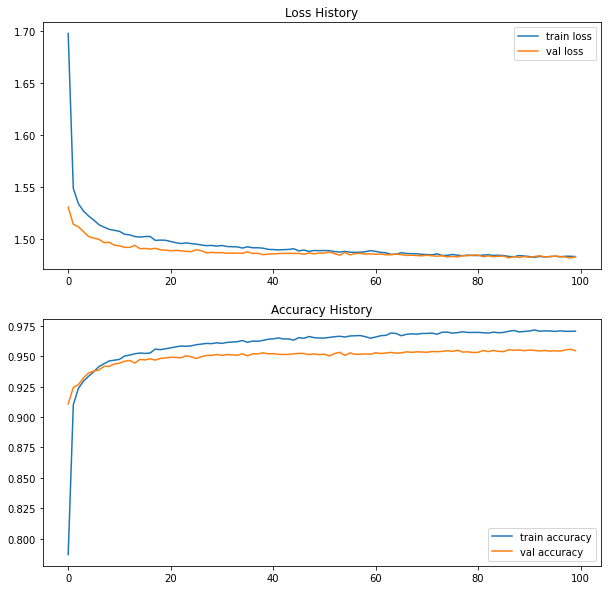

In [21]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Loss History')
plt.plot(np.arange(epochs-1), train_loss_history, label='train loss')
plt.plot(np.arange(epochs-1), val_loss_history, label='val loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Accuracy History')
plt.plot(np.arange(epochs-1), train_accuracy_history, label='train accuracy')
plt.plot(np.arange(epochs-1), val_accuracy_history, label='val accuracy')
plt.legend()
plt.show()

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*

6). *Подробнее про backprop -- статья на Medium: https://medium.com/autonomous-agents/backpropagation-how-neural-networks-learn-complex-behaviors-9572ac161670*

7). *Статья из интернет по Backprop: http://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf*